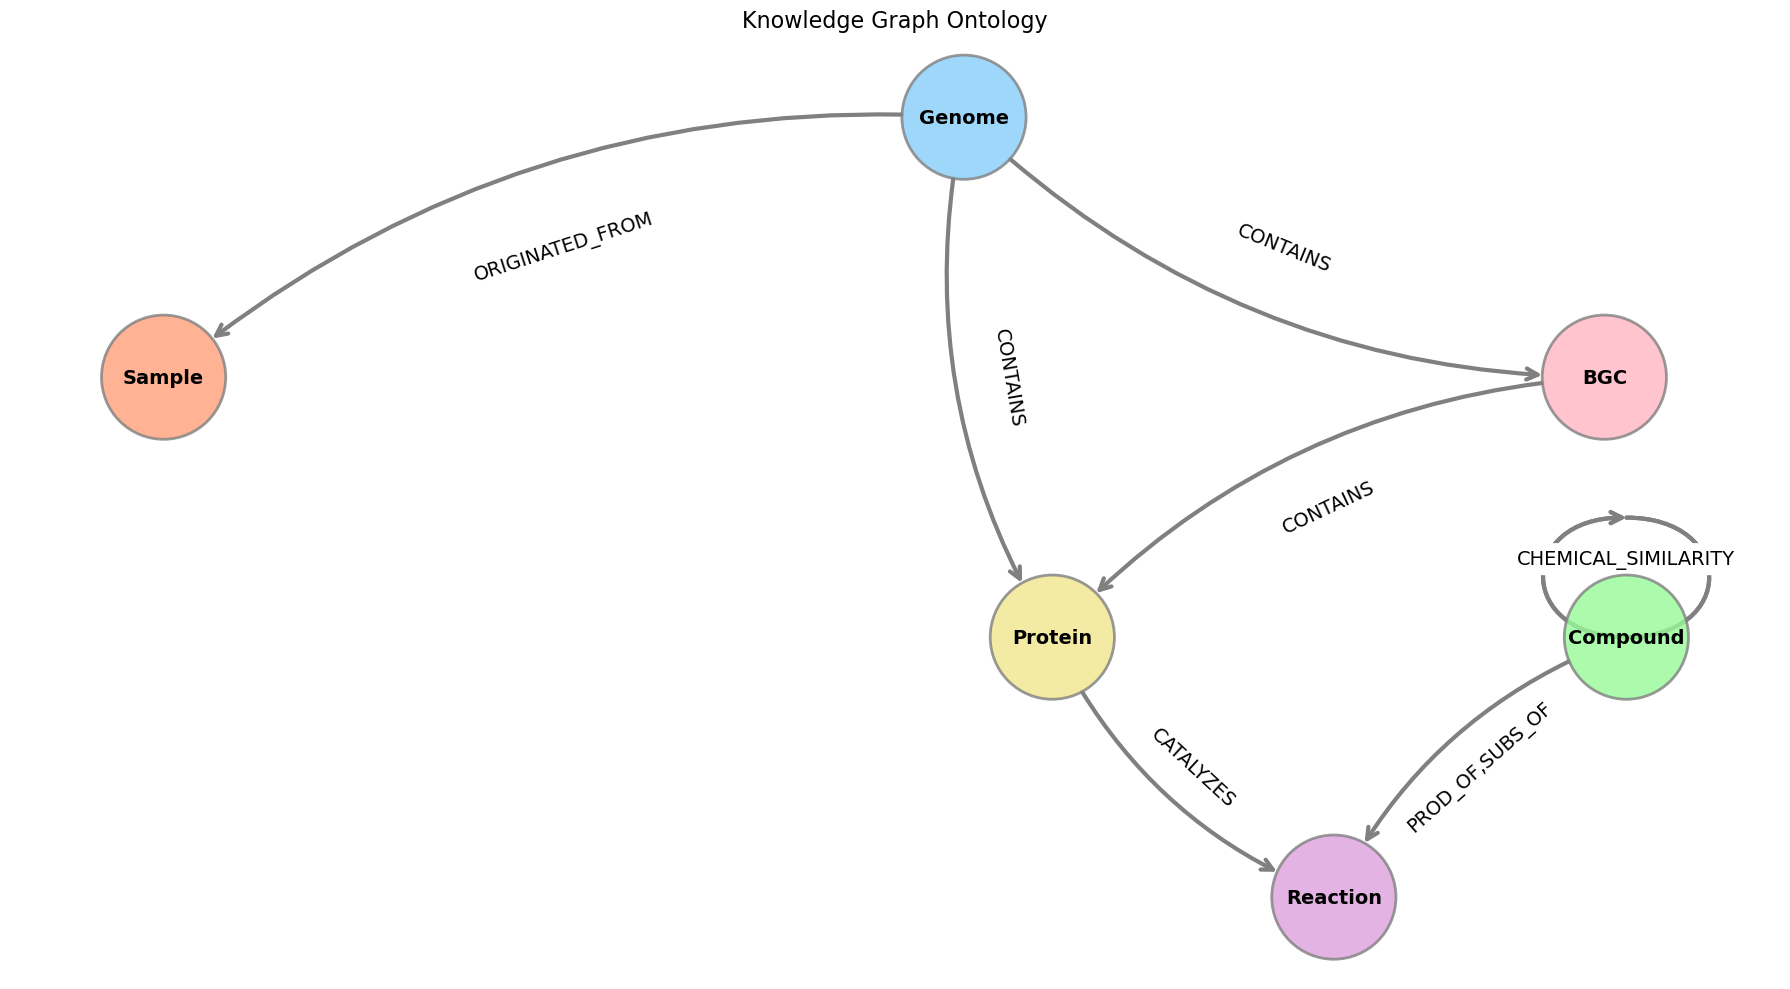

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import pygraphviz as pgv

def parse_input_data(nodes_str, relationships_str):
    nodes = json.loads(nodes_str)
    relationships = json.loads(relationships_str)
    return nodes, relationships

def create_graph(nodes, relationships):
    G = nx.MultiDiGraph()
    
    for node in nodes:
        G.add_node(node['properties']['name'], **node['properties'])
    
    for rel in relationships:
        start_node = next(n['properties']['name'] for n in nodes if n['identity'] == rel['start'])
        end_node = next(n['properties']['name'] for n in nodes if n['identity'] == rel['end'])
        G.add_edge(start_node, end_node, label=rel['type'])
    
    if 'Compound' in G.nodes():
        G.add_edge('Compound', 'Compound', label='CHEMICAL_SIMILARITY', weight=5) 
        #G.add_edge('Compound', 'Reaction', label='PRODUCT_OF')
        # G.add_edge('Compound', 'Reaction', label='SUBSTRATE_OF')
    
    return G

def visualize_graph(G):
    import numpy as np
    plt.figure(figsize=(18, 10))
    ax = plt.gca()

    color_map = {
        'Sample': '#FFA07A',
        'Compound': '#98FB98',
        'Genome': '#87CEFA',
        'Reaction': '#DDA0DD',
        'Protein': '#F0E68C',
        'BGC': '#FFB6C1'
    }

    # Use pygraphviz for layout
    A = nx.nx_agraph.to_agraph(G)
    A.layout('dot')
    # Convert positions back to a dictionary for NetworkX
    pos = nx.nx_agraph.pygraphviz_layout(G, prog="dot")

    node_size = 8000  # Define node size

    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_color=[color_map[node] for node in G.nodes()],
        node_size=node_size,
        alpha=0.8,
        edgecolors='gray',
        linewidths=2
    )

    # Get edges
    edges = list(G.edges(data=True, keys=True))

    # Build edgelists
    edges_self_loop = []
    edges_non_self_loop = []

    for (u, v, k, d) in edges:
        if u == v and d.get('label') == 'CHEMICAL_SIMILARITY':
            edges_self_loop.append((u, v))
        else:
            edges_non_self_loop.append((u, v))

    # Draw non-self-loop edges
    nx.draw_networkx_edges(
        G, pos,
        edgelist=edges_non_self_loop,
        edge_color='gray',
        arrows=True,
        arrowsize=20,
        arrowstyle='->',
        connectionstyle='arc3,rad=0.20',
        node_size=node_size,
        width=3,
    )

    # Draw self-loop edges
    edge_patches_self_loop = nx.draw_networkx_edges(
        G, pos,
        edgelist=edges_self_loop,
        edge_color='gray',
        arrows=True,
        arrowsize=20,
        arrowstyle='->',
        node_size=node_size,
        width=3,
    )

    # Define the SelfLoop class
    class SelfLoop():
        def __init__(self, v_scale=2, h_scale=1, nodesize=100):
            self.v_scale = v_scale
            self.h_scale = h_scale
            self.nodesize = nodesize

        def selfloopstyle(self, posA, posB, *args, **kwargs):
            from matplotlib.path import Path

            selfloop_ht = 0.005 * self.nodesize

            data_loc = ax.transData.inverted().transform(posA)
            v_shift = self.v_scale * selfloop_ht
            h_shift = v_shift * self.h_scale

            path = [
                data_loc + np.asarray([0, v_shift]),
                data_loc + np.asarray([h_shift, v_shift]),
                data_loc + np.asarray([h_shift, 0]),
                data_loc,
                data_loc + np.asarray([-h_shift, 0]),
                data_loc + np.asarray([-h_shift, v_shift]),
                data_loc + np.asarray([0, v_shift]),
            ]

            ret = Path(ax.transData.transform(path), [1, 4, 4, 4, 4, 4, 4])

            return ret

        def style(self):
            return self.selfloopstyle

    # Modify the _connector property of the self-loop edge patches
    for edge_patch in edge_patches_self_loop:
        edge_patch._connector = SelfLoop(v_scale=1, h_scale=0.5, nodesize=node_size).style()
        ax.add_patch(edge_patch)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold")

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)

    plt.title("Knowledge Graph Ontology", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("KG_ontology.png", dpi=300)
    plt.show()


# Main execution
def main():
    nodes_str = '''[
  {"identity": -111, "labels": ["Sample"], "properties": {"name": "Sample", "indexes": ["fraction", "sample_type", "biosample_id", "division", "sra_run_id", "name"], "constraints": []}, "elementId": "-111"},
  {"identity": -106, "labels": ["Compound"], "properties": {"name": "Compound", "indexes": ["name", "formula", "sources", "aliases", "compound_id", "compound_id"], "constraints": []}, "elementId": "-106"},
  {"identity": -107, "labels": ["Genome"], "properties": {"name": "Genome", "indexes": ["genome_id", "size", "source_biosample", "gtdb_version", "source_biosample_id", "name", "genome_cluster_id", "genome_id", "gtdb_classification"], "constraints": []}, "elementId": "-107"},
  {"identity": -108, "labels": ["Reaction"], "properties": {"name": "Reaction", "indexes": ["aliases", "products", "reaction_id", "compound_ids", "substrates", "equation", "pathways", "ec_numbers", "source", "reaction_id", "linked_reaction", "name", "status", "ec_numbers"], "constraints": []}, "elementId": "-108"},
  {"identity": -110, "labels": ["Protein"], "properties": {"name": "Protein", "indexes": ["ec_numbers", "genome_id", "genome_id", "protein_id", "id", "contig_id", "protein_id", "name", "kegg_ortholog_id", "ec_numbers"], "constraints": []}, "elementId": "-110"},
  {"identity": -109, "labels": ["BGC"], "properties": {"name": "BGC", "indexes": ["genome_id", "contig_id", "tool", "bgc_id", "genome_id", "bgc_id", "bgc_class"], "constraints": []}, "elementId": "-109"}
]'''

    relationships_str = '''[
  {"identity": -111, "start": -106, "end": -108, "type": "PROD_OF,SUBS_OF", "properties": {"name": "PRODUCT_OF/SUBSTRATE_OF"}, "elementId": "-111", "startNodeElementId": "-106", "endNodeElementId": "-108"},
  {"identity": -113, "start": -110, "end": -108, "type": "CATALYZES", "properties": {"name": "CATALYZES"}, "elementId": "-113", "startNodeElementId": "-110", "endNodeElementId": "-108"},
  {"identity": -107, "start": -107, "end": -109, "type": "CONTAINS", "properties": {"name": "CONTAINS"}, "elementId": "-107", "startNodeElementId": "-107", "endNodeElementId": "-109"},
  {"identity": -108, "start": -107, "end": -110, "type": "CONTAINS", "properties": {"name": "CONTAINS"}, "elementId": "-108", "startNodeElementId": "-107", "endNodeElementId": "-110"},
  {"identity": -109, "start": -107, "end": -111, "type": "ORIGINATED_FROM", "properties": {"name": "ORIGINATED_FROM"}, "elementId": "-109", "startNodeElementId": "-107", "endNodeElementId": "-111"},
  {"identity": -114, "start": -109, "end": -110, "type": "CONTAINS", "properties": {"name": "CONTAINS"}, "elementId": "-114", "startNodeElementId": "-109", "endNodeElementId": "-110"}
]'''

    nodes, relationships = parse_input_data(nodes_str, relationships_str)
    G = create_graph(nodes, relationships)
    visualize_graph(G)

if __name__ == "__main__":
    main()